In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import absolute
import warnings
warnings.filterwarnings('ignore')

Data Analysis

In [3]:
# Training Data

train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Testing Data

test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# Saving ID on a new variable and Dropping ID column

train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [6]:
# Plotting to find outliers 
# for items in train.columns:
#     if len(train[items].unique()) < 20:
#         sns.catplot(x=train[items], y=train['SalePrice'], data=train)
#         plt.show()
#     else:
#         sns.scatterplot(x=train[items],y=train['SalePrice'])
#         plt.show()

In [7]:
# Removing Outlier
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
print(train.shape)

(1458, 80)


Visualizing output data from train set

<AxesSubplot:>

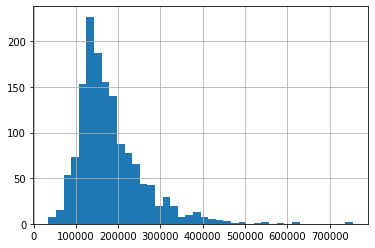

In [8]:
# Plotting output data for Visualization
train['SalePrice'].hist(bins = 40)

Data is skewed, we will use log1p to remove the skewness in data

<AxesSubplot:>

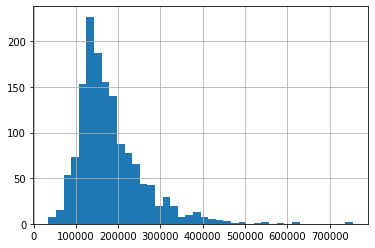

In [9]:
# Adjusting for Skewness
# train["SalePrice"] = np.log1p(train["SalePrice"])
train["SalePrice"] = train["SalePrice"]
y_train = train['SalePrice'].reset_index(drop=True)

train['SalePrice'].hist(bins = 40)

In [10]:
# Concat Testing part of both Train and Test and split SalePrice from Train data for Training
train_data = train.drop(['SalePrice'], axis=1)
total_data = pd.concat([train_data, test]).reset_index(drop=True)

In [11]:
# Total data is full data to be used for EDA
total_data.shape

(2917, 79)

In [12]:
print('columns containing missing values =',total_data.isnull().any().sum())

columns containing missing values = 34


                 0
PoolQC        2908
MiscFeature   2812
Alley         2719
Fence         2346
FireplaceQu   1420
LotFrontage    486
GarageYrBlt    159
GarageFinish   159
GarageQual     159
GarageCond     159
GarageType     157
BsmtExposure    82
BsmtCond        82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
MasVnrType      24
MasVnrArea      23
MSZoning         4
Functional       2
BsmtHalfBath     2
BsmtFullBath     2
Utilities        2
SaleType         1
BsmtFinSF1       1
KitchenQual      1
GarageCars       1
BsmtUnfSF        1
TotalBsmtSF      1
Exterior2nd      1
Exterior1st      1
GarageArea       1
Electrical       1
BsmtFinSF2       1


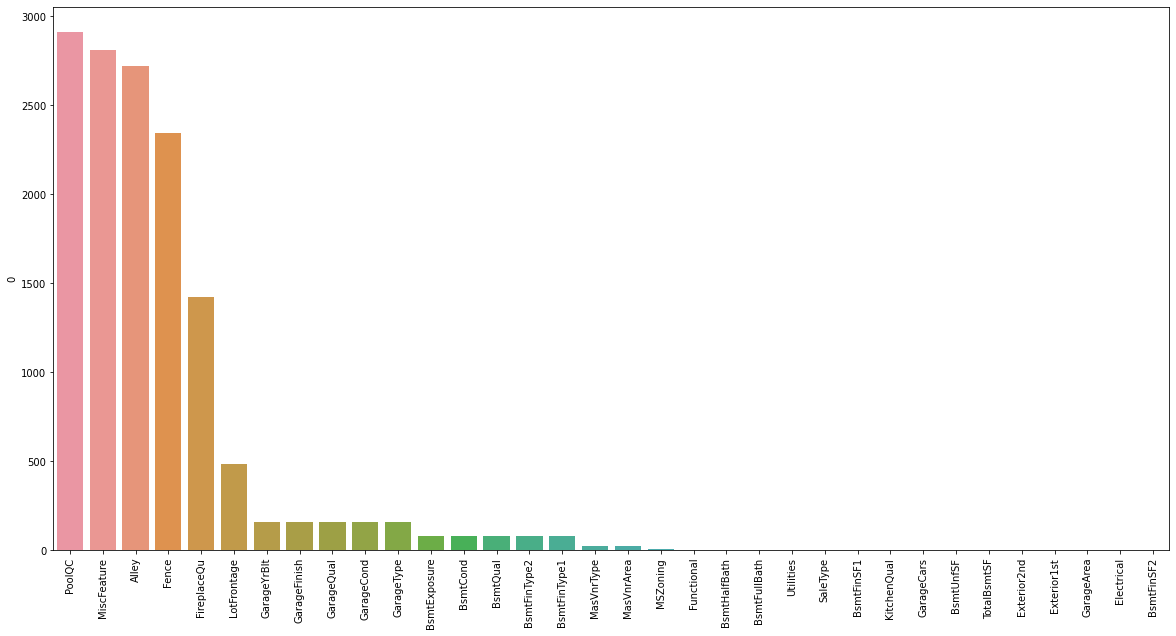

In [13]:
# Finding missing values to plot a Graph
missing_counts = pd.DataFrame(total_data.isnull().sum().sort_values(ascending=False))
missing_columns = missing_counts[missing_counts.iloc[:,0]>0]
# Plotting Missing Values
plt.figure(figsize=(20,10))
missing_columns = missing_counts[missing_counts.iloc[:,0]>0]
sns.barplot(x=missing_columns.index,y=missing_columns.iloc[:,0])
plt.xticks(rotation=90)
print(missing_columns)
plt.show()

In [14]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
total_data['MSSubClass'] = total_data['MSSubClass'].apply(str)
total_data['YrSold'] = total_data['YrSold'].astype(str)
total_data['MoSold'] = total_data['MoSold'].astype(str)

# Fixing columns : filling Null values with suitable values in columns
total_data['Functional'] = total_data['Functional'].fillna('Typ')
total_data['Electrical'] = total_data['Electrical'].fillna("SBrkr")
total_data['KitchenQual'] = total_data['KitchenQual'].fillna("TA")
total_data['Exterior1st'] = total_data['Exterior1st'].fillna(total_data['Exterior1st'].mode()[0])
total_data['Exterior2nd'] = total_data['Exterior2nd'].fillna(total_data['Exterior2nd'].mode()[0])
total_data['SaleType'] = total_data['SaleType'].fillna(total_data['SaleType'].mode()[0])
total_data["PoolQC"] = total_data["PoolQC"].fillna("None")

In [15]:
# Filling columns with Mode and Median values
total_data["LotFrontage"].fillna(total_data["LotFrontage"].median(),inplace=True)
total_data["MSZoning"].fillna(total_data["MSZoning"].mode(),inplace=True)

In [16]:
# Filling some columns Nan values with 0's

for item in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    total_data[item] = total_data[item].fillna(0)

# Filling categorial columns Nan Values with 'None'

for item in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    total_data[item] = total_data[item].fillna('None')

In [17]:
# Filling remaining Object type columns Nan values with None
objects = []
for i in total_data.columns:
    if total_data[i].dtype == object:
        objects.append(i)
total_data.update(total_data[objects].fillna('None'))

In [18]:
# Filling remaining Numerical type columns with 0 values
numerical = total_data.select_dtypes(include=np.number).columns.tolist()
for i in numerical:
    total_data.update(total_data[i].fillna(0))

Data Engineering

In [19]:
# Dropping unwanted columns
total_data = total_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

In [20]:
# Engineered new columns 
total_data['YrBltAndRemod']=total_data['YearBuilt']+total_data['YearRemodAdd']
total_data['TotalSF']=total_data['TotalBsmtSF'] + total_data['1stFlrSF'] + total_data['2ndFlrSF']

total_data['Total_sqr_footage'] = (total_data['BsmtFinSF1'] + total_data['BsmtFinSF2'] +
                                 total_data['1stFlrSF'] + total_data['2ndFlrSF'])

total_data['Total_Bathrooms'] = (total_data['FullBath'] + (0.5 * total_data['HalfBath']) +
                               total_data['BsmtFullBath'] + (0.5 * total_data['BsmtHalfBath']))

total_data['Total_porch_sf'] = (total_data['OpenPorchSF'] + total_data['3SsnPorch'] +
                              total_data['EnclosedPorch'] + total_data['ScreenPorch'] +
                              total_data['WoodDeckSF'])

In [21]:
# Simplifying Features
total_data['haspool'] = total_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
total_data['has2ndfloor'] = total_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
total_data['hasgarage'] = total_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
total_data['hasbsmt'] = total_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
total_data['hasfireplace'] = total_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [22]:
# Adding pandas dummy values to encode features
print(total_data.shape)
final_data = pd.get_dummies(total_data).reset_index(drop=True)
print(final_data.shape)

(2917, 86)
(2917, 334)


In [23]:
# Splitting Train and test values now with help of variable 'y' 
x_train = final_data.iloc[:len(y_train), :]
x_test = final_data.iloc[len(x_train):, :]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)

x_train (1458, 334)
y_train (1458,)
x_test (1459, 334)


In [24]:
# Removing Overfitting features
overfit = []
for i in x_train.columns:
    counts = x_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(x_train) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
# MSZoning_C have an extra field added in data 
overfit.append('MSZoning_C (all)')

X_train = x_train.drop(overfit, axis=1).copy()
X_test = x_test.drop(overfit, axis=1).copy()
Y_train = y_train.copy()

print('X_train', X_train.shape)
print('Y_train', Y_train.shape)
print('X_test', X_test.shape)

X_train (1458, 331)
Y_train (1458,)
X_test (1459, 331)


Trying a Neural network model on above

In [25]:
from sklearn.model_selection import train_test_split
x_train1,x_test1,y_train1,y_test1=train_test_split(X_train,Y_train,test_size=.20,random_state=40)
print('x_train1', x_train1.shape)
print('y_train1', y_train1.shape)
print('x_test1', x_test1.shape)
print('y_test1', y_test1.shape)

x_train1 (1166, 331)
y_train1 (1166,)
x_test1 (292, 331)
y_test1 (292,)


In [26]:
# Learning rate
learning_rate = 0.1

# Epoch  
epochs = 400

# Batch size
batch_size = 5

In [27]:
# Sequential Model
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(118, activation='relu', kernel_initializer='normal', input_dim = 331))
model.add(Dense(59, activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

In [28]:
# Complie the model

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [29]:
# Model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 118)               39176     
_________________________________________________________________
dense_1 (Dense)              (None, 59)                7021      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 60        
Total params: 46,257
Trainable params: 46,257
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Model Training

history = model.fit(
    x_train1,
    y_train1,
    batch_size=batch_size,
    epochs=epochs,
    verbose = 0
)

In [31]:
# Prediction on train and test data 
from sklearn.metrics import mean_squared_error

# pred_test= np.expm1(model.predict(x_test1))
pred_test= model.predict(x_test1)

# Printing RMSE with on val data
print(np.sqrt(mean_squared_error(y_test1,pred_test))) 

26155.01162526931


In [32]:
# pred_test

In [33]:
# R square score for the model
from sklearn.metrics import r2_score
r_square = r2_score(y_test1, pred_test)
r_square

0.8691635803354488

In [34]:
#here we predict SalePrice using NN Model
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
# submission.iloc[:,1] = (np.expm1(model.predict(X_test)))
submission.iloc[:,1] = model.predict(X_test)

In [35]:
# Output
submission.head()

,Id,SalePrice
0,1461,111946.617188
1,1462,164133.453125
2,1463,176509.562500
3,1464,185557.390625
4,1465,176173.546875


In [36]:
# Submission
submission.to_csv("submission.csv", index=False)

In [37]:
# Still have to implement XGBoost and Ensembler model - WIP